In [1]:
# Các thư viện cần thiết
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('../../Dataset/Gold.csv')
df.shape

(1694, 5)

In [3]:
# Kiểm tra cột close có hàng nào null không
df['Close'].isnull().sum()

0

In [4]:
# Đưa về kiểu date và đánh index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'])

# Sắp xếp lại index
df = df.sort_index(ascending=True)
df = df.drop(columns=['Open', 'High', 'Low'])
df

,Close
Date,
2019-03-01,1292.765
2019-03-02,1292.765
2019-03-03,1292.765
2019-03-04,1286.710
2019-03-05,1287.775
...,...
2024-03-22,2165.400
2024-03-23,2165.400
2024-03-24,2165.990


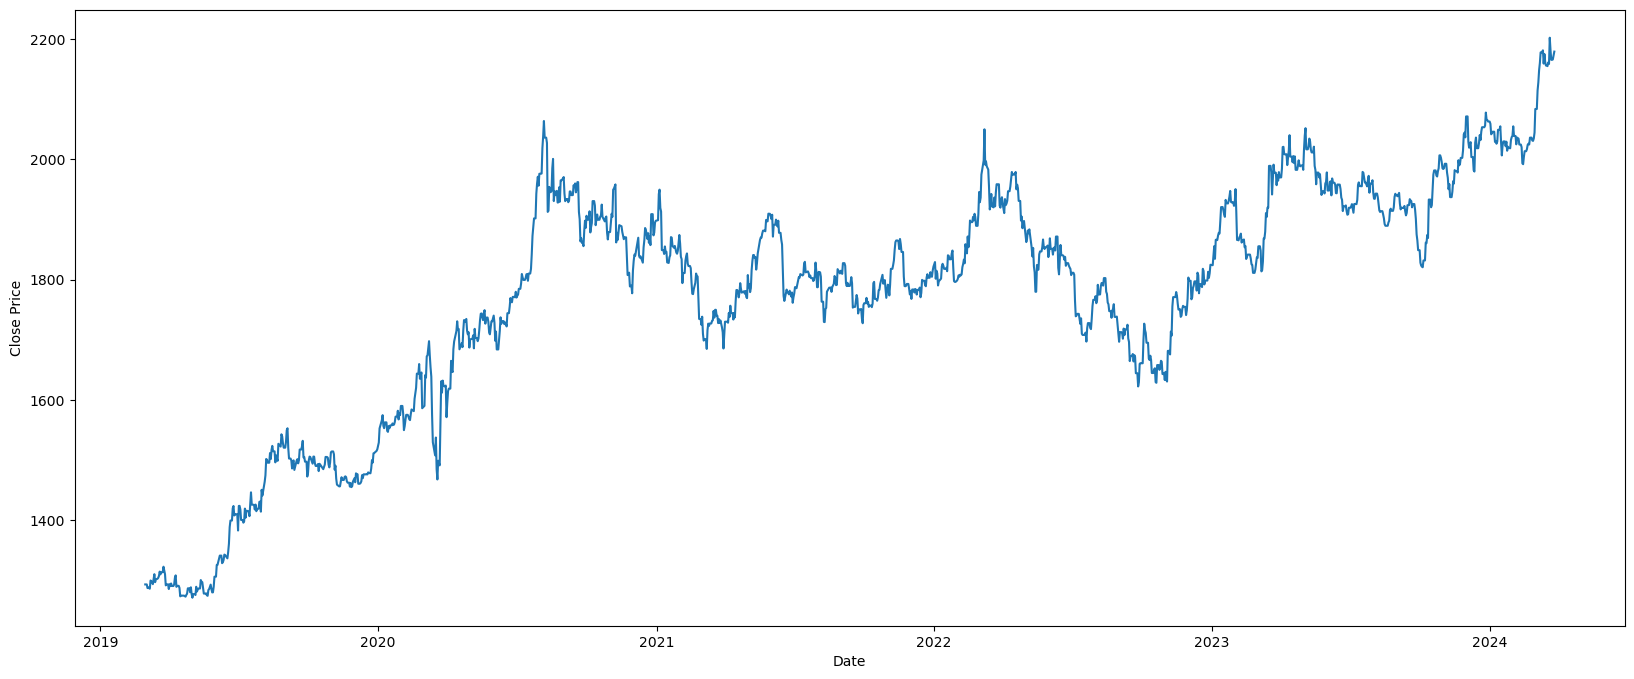

In [5]:
# Vẽ biểu đồ chuỗi thời gian
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [6]:
# Chia train test theo tỉ lệ
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [7]:
# Chia các tập x,y train, test tương ứng
x_train = np.array(train_data.index).reshape(-1, 1)  #Lấy chỉ mục Index
y_train = np.array(train_data['Close']) #Lấy dữ liệu giá Close

x_test = np.array(test_data.index).reshape(-1, 1)  #Lấy chỉ mục Index
y_test = np.array(test_data['Close']) #Lấy dữ liệu giá Close

In [8]:
# Quá trình training
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Fit mô hình với các tham số tốt nhất được tìm kiếm
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9851.773, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9847.913, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9849.901, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9849.900, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9846.346, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9849.007, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.501 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
# Tóm tắt model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1185
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4922.173
Date:                Thu, 30 May 2024   AIC                           9846.346
Time:                        16:26:37   BIC                           9851.422
Sample:                             0   HQIC                          9848.259
                               - 1185                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       239.0350      4.921     48.572      0.000     229.390     248.680
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1898.38
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.73
Prob(H) (two-sided):                  0.61   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Quá trình testing 
y_pred = model.predict(n_periods=len(x_test))

In [11]:
# Tính MSE - Mean Squared Error - Sai số bình phương trung bình
test_mse = mean_squared_error(y_test, y_pred) 
print('Testing MSE:', test_mse)

# Tính RMSE - Root Mean Squared Error - Sai số bình phương trung bình
test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

# Tính MAPE - Mean Absolute Percentage Error - Tỷ lệ phần trăm sai số tuyệt đối trung bình
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 100042.39095343814
Testing RMSE: 316.29478489763017
Testing MAPE: 0.15206576846001474


Giá Close dự đoán:
[1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76]


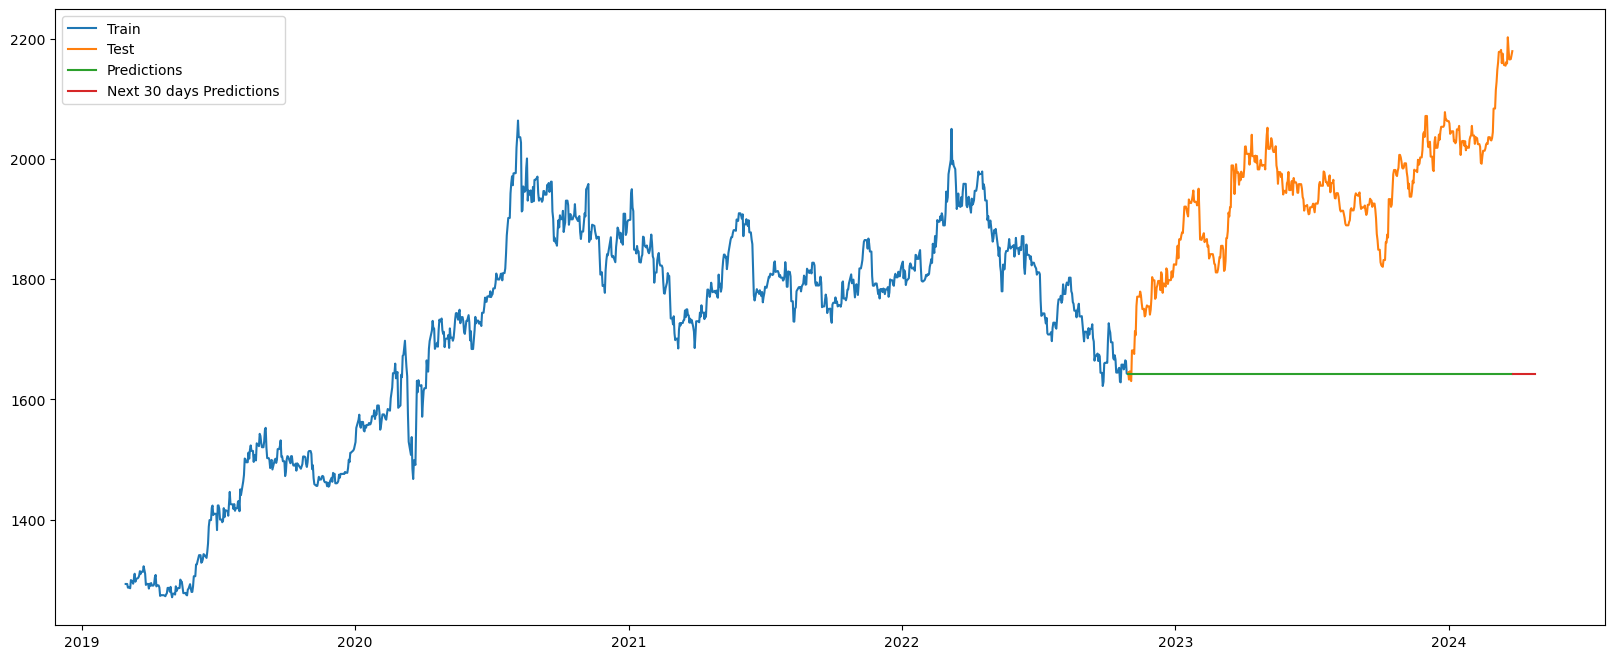

In [12]:
# Dự đoán 30 ngày
predict_days = 30

# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))

# Chuyển đổi sang NumPy array và reshape
x_next = np.array(date_range).reshape(-1, 1)

# Tạo ra mảng dữ liệu dự đoán của y_next
y_next = model.predict(n_periods=len(x_next))

# In ra dữ liệu dự đoán
print('Giá Close dự đoán:')
print(y_next)

# Vẽ hình
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.plot(x_next, y_next)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 days Predictions'])
plt.show()

Giá Close dự đoán:
[1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76]


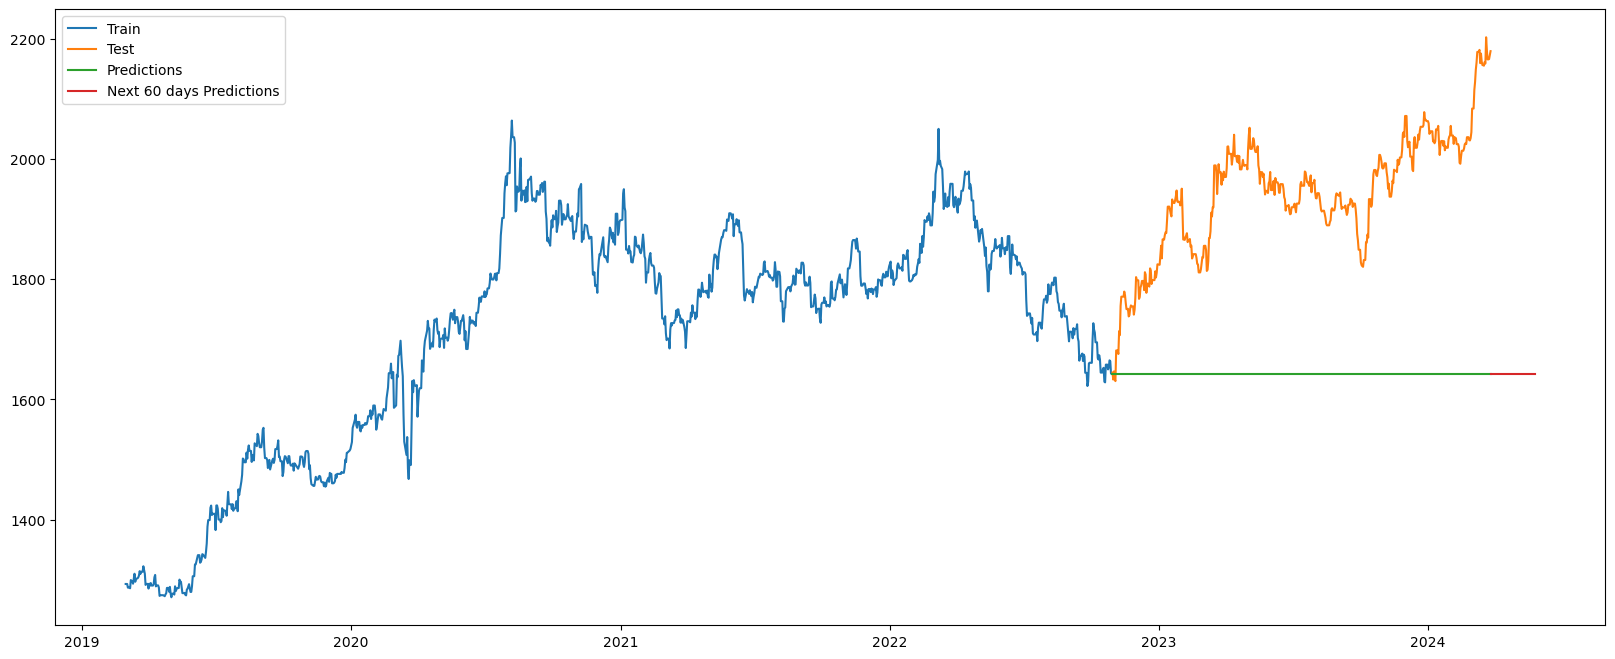

In [13]:
# Dự đoán 60 ngày
predict_days = 60

# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))

# Chuyển đổi sang NumPy array và reshape
x_next = np.array(date_range).reshape(-1, 1)

# Tạo ra mảng dữ liệu dự đoán của y_next
y_next = model.predict(n_periods=len(x_next))

# In ra dữ liệu dự đoán
print('Giá Close dự đoán:')
print(y_next)

# Vẽ hình
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.plot(x_next, y_next)
plt.legend(['Train', 'Test', 'Predictions', 'Next 60 days Predictions'])
plt.show()

Giá Close dự đoán:
[1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76
 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76 1642.76]


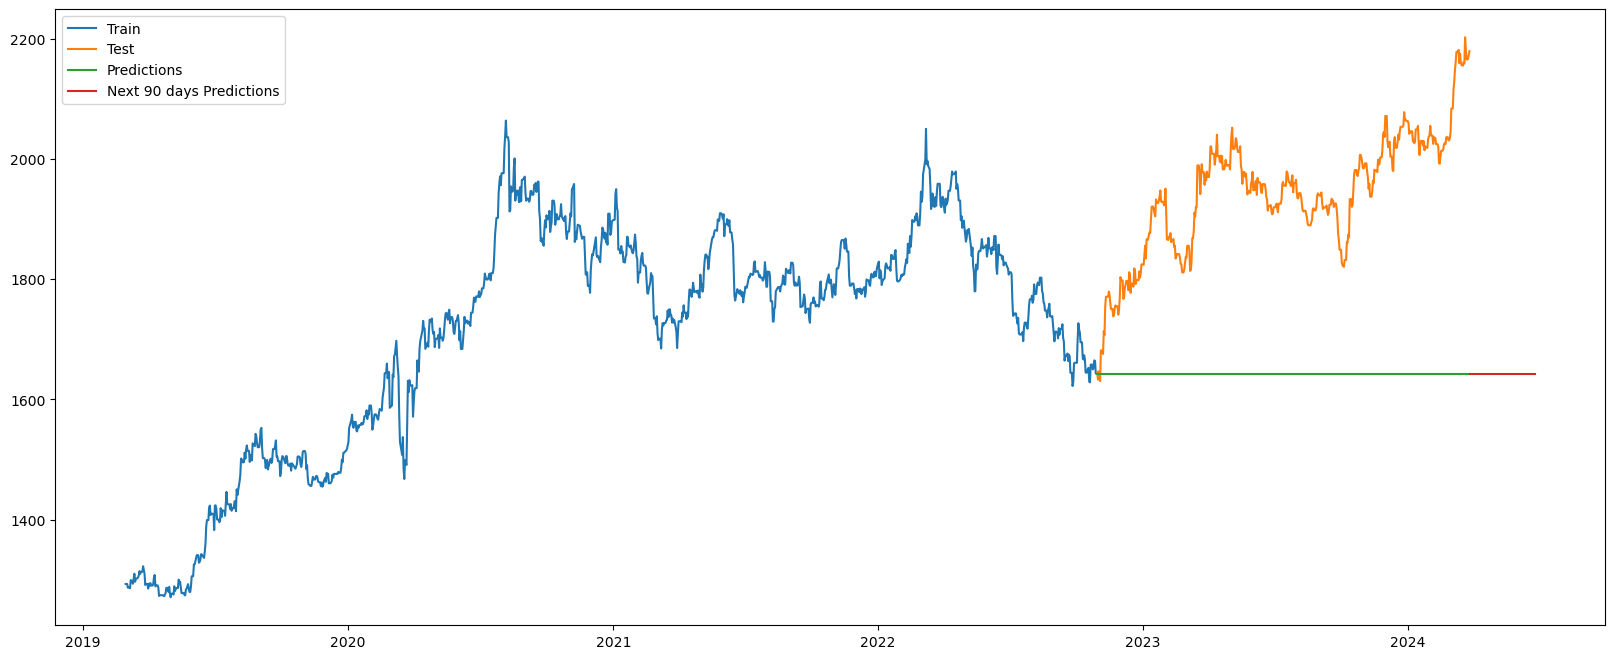

In [14]:
# Dự đoán 90 ngày
predict_days = 90

# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))

# Chuyển đổi sang NumPy array và reshape
x_next = np.array(date_range).reshape(-1, 1)

# Tạo ra mảng dữ liệu dự đoán của y_next
y_next = model.predict(n_periods=len(x_next))

# In ra dữ liệu dự đoán
print('Giá Close dự đoán:')
print(y_next)

# Vẽ hình
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.plot(x_next, y_next)
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions'])
plt.show()